In [1]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
%matplotlib notebook

import requests
from IPython.display import Image

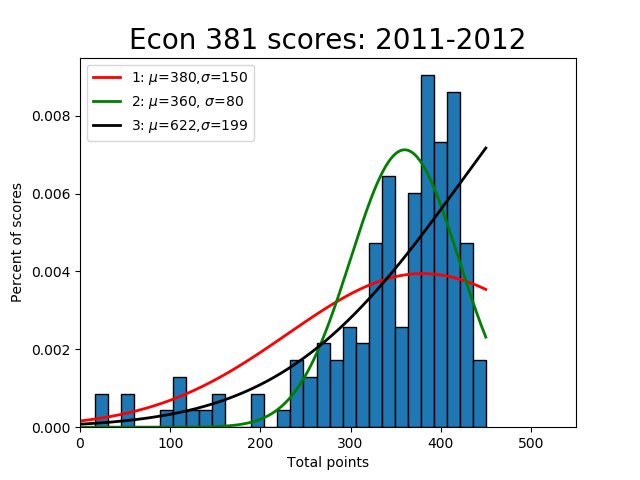

In [2]:
url = ('https://raw.githubusercontent.com/rickecon/Notebooks/' +
       'master/GMM/images/MLEplots.png')
image_file = requests.get(url, allow_redirects=True)
open('images/MLEplots.png', 'wb').write(image_file.content)
Image("images/MLEplots.png")



In [5]:
# Download and save the data file Econ381totpts.txt
url = ('https://raw.githubusercontent.com/rickecon/Notebooks/' +
'master/GMM/data/Econ381totpts.txt')
data_file = requests.get(url, allow_redirects=True)
open('data/Econ381totpts.txt', 'wb').write(data_file.content)
# Load the data as a NumPy array
pts = np.loadtxt('data/Econ381totpts.txt')

In [17]:

def trunc_norm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.norm.cdf(cut_lb, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.norm.cdf(cut_ub, loc=mu, scale=sigma) -
                       sts.norm.cdf(cut_lb, loc=mu, scale=sigma))
    
    pdf_vals = ((1/(sigma * np.sqrt(2*np.pi)) *
                np.exp(-(xvals - mu) ** 2 / (2 * sigma**2)))/
               prob_notcut)
    
    return pdf_vals


In [20]:
def data_moments(xvals):
    
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data

def model_moments(mu, sigma, cut_lb, cut_ub):
    
    xfx = lambda x: x * trunc_norm_pdf(x, mu, sigma, cut_lb, cut_ub)
    mean_model, v_m_err = intgr.quad(xfx, cut_lb, cut_ub)
    
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_norm_pdf(x, mu, sigma, cut_lb, cut_ub)
    var_model, v_m_err = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, var_model


def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val




In [72]:
pts.mean()

341.90869565217395

In [21]:
mu_init = 400
sig_init = 60
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, 0.0, 450.0, W_hat)

res = opt.minimize(criterion, params_init, args=(gmm_args))
res = opt.minimize(criterion, params_init, args=(gmm_args),
                   tol=1e-14, method='L-BFGS-B',
                   bounds=((1e-10, None), (1e-10, None)))

mu_GMM1, sig_GMM1 = res.x
print('mu_GMM1=', mu_GMM1, 'sig_GMM1=', sig_GMM1)
res


mu_GMM1= 622.0452986374754 sig_GMM1= 198.72061653106567


      fun: array([[2.77463255e-18]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.94403613e-13,  7.44479927e-13])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 19
   status: 0
  success: True
        x: array([622.04529864, 198.72061653])

In [23]:
mean_data, var_data = data_moments(pts)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 450.0)
err1 = err_vec(pts, mu_GMM1, sig_GMM1, 0.0, 450.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Meas of model =', mean_model, ', Variance of model =', var_model)
print('Error vector =', err1)
res

Mean of points = 341.90869565217395 , Variance of points = 7827.997292398056
Meas of model = 341.9086950941956 , Variance of model = 7827.997289785716
Error vector = [-1.63195134e-09 -3.33717516e-10]


      fun: array([[2.77463255e-18]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.94403613e-13,  7.44479927e-13])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 19
   status: 0
  success: True
        x: array([622.04529864, 198.72061653])

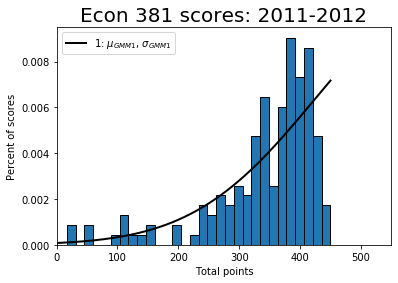

In [28]:
num_bins = 30
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                               edgecolor='k')
plt.title('Econ 381 scores: 2011-2012', fontsize=20)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent of scores')
plt.xlim([0, 550])


dist_pts = np.linspace(0, 450, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 450),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$, $\sigma_{GMM1}$')
plt.legend(loc='upper left')

Text(0.5, 0, 'Crit. func.')

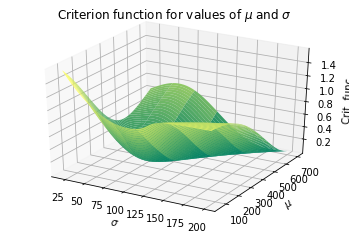

In [30]:
mu_vals = np.linspace(60, 700, 50)
sig_vals = np.linspace(20, 200, 50)
crit_vals = np.zeros((50,50))
for mu_ind in range(50):
    for sig_ind in range(50):
        crit_vals[mu_ind, sig_ind] = \
        criterion(np.array([mu_vals[mu_ind], sig_vals[sig_ind]]),
                 pts, 0.0, 450.0, W_hat)

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(sig_mesh, mu_mesh, crit_vals, rstride=8,
                cstride=1, cmap=cmap1)
ax.set_title('Criterion function for values of $\mu$ and $\sigma$')
ax.set_xlabel('$\sigma$')
ax.set_ylabel('$\mu$')
ax.set_zlabel('Crit. func.')

In [31]:
def Jac_err2(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    Jac_err = np.zeros((2,2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = ((err_vec(xvals, mu+h_mu, sigma, cut_lb, cut_ub, simple)-
                     err_vec(xvals, mu-h_mu, sigma, cut_lb, cut_ub, simple)) / (2 
                    * h_mu)).flatten()
    Jac_err[:, 1] = ((err_vec(xvals, mu, sigma + h_sig, cut_lb, cut_ub, simple) -
                     err_vec(xvals, mu, sigma - h_sig, cut_lb, cut_ub, simple)) / (2
                    * h_sig)).flatten()
    
    return Jac_err

In [36]:
N = pts.shape[0]
d_err2 = Jac_err2(pts, mu_GMM1, sig_GMM1, 0.0, 450.0, False)
print(d_err2)
print(W_hat)
SigHat2 = (1/N) * lin.inv(d_err2.T @ W_hat @ d_err2)
print(SigHat2)
print('Std. err. mu_hat =', np.sqrt(SigHat2[0, 0]))
print('Std. err. sig_hat =', np.sqrt(SigHat2[1, 1]))


[[ 0.00057977 -0.00191677]
 [-0.00244916  0.00973172]]
[[1. 0.]
 [0. 1.]]
[[680416.89793523 172529.89118262]
 [172529.89118262  43810.67128873]]
Std. err. mu_hat = 824.8738678944987
Std. err. sig_hat = 209.30998850682803


In [37]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    
    if simple:
        rr_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - var_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - var_model) / var_model
    return Err_mat



In [38]:
Err_mat = get_Err_mat2(pts, mu_GMM1, sig_GMM1, 0.0, 450.0, False)
VCV2 = (1 / pts.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = lin.inv(VCV2)
print(W_hat2)


[[ 0.0669623  -0.43803414]
 [-0.43803414  4.78818521]]
[[37.18863472  3.40210144]
 [ 3.40210144  0.52007942]]


In [39]:
mu_init = 400
sig_init = 60
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (pts, 0.0, 450.0, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None),
                       (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)


mu_GMM2= 622.0452986374754  sig_GMM2= 198.72061653106567


In [41]:
d_err2_2 = Jac_err2(pts, mu_GMM2, sig_GMM2, 0.0, 450.0, False)
print(d_err2_2)
print(W_hat2)
SigHat2_2 = (1 / N) * lin.inv(d_err2.T @ W_hat2 @ d_err2)
print(SigHat2_2)
print('Std. err. mu_hat=', np.sqrt(SigHat2_2[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHat2_2[1, 1]))




[[ 0.00057977 -0.00191677]
 [-0.00244916  0.00973172]]
[[37.18863472  3.40210144]
 [ 3.40210144  0.52007942]]
[[52507.02967863 16524.55383619]
 [16524.55383619  5305.80108996]]
Std. err. mu_hat= 229.14412425072527
Std. err. sig_hat= 72.84093004592545


In [43]:
def data_moments4(xvals):
    
    bpct_1_dat = xvals[xvals < 220].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=220) & (xvals < 320)].shape[0] / xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=320) & (xvals < 430)].shape[0] /
                  xvals.shape[0])
    bpct_4_dat = xvals[xvals >= 430].shape[0] / xvals.shape[0]
    
    return bpct_1_dat, bpct_2_dat, bpct_3_dat, bpct_4_dat

def model_moments4(mu, sigma, cut_lb, cut_ub):
    
    xfx = lambda x: trunc_norm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 220)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 220, 320)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 320, 430)
    (bpct_4_mod, bp_4_err) = intgr.quad(xfx, 430, 450)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod

def err_vec4(xvals, mu, sigma, cut_lb, cut_ub, simple):
    
    bpct_1_dat, bpct_2_dat, bpct_3_dat, bpct_4_dat = data_moments4(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat], [bpct_4_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod = model_moments4(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod], [bpct_4_mod]])
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion4(params, *args):
    
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec4(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

params = np.array([mu_GMM1, sig_GMM1])
print('params=', params)
print(data_moments4(pts))
print(model_moments4(mu_GMM1, sig_GMM1, 0.0, 450))
print(criterion4(params, pts, 0.0, 450.0, np.eye(4)))
    
    

params= [622.04529864 198.72061653]
(0.08695652173913043, 0.17391304347826086, 0.6894409937888198, 0.049689440993788817)
(0.10733213608587798, 0.22206800780274738, 0.5334651290315178, 0.13713472707985683)
[[3.2797808]]


In [44]:
mu_init = 400
sig_init = 70
params_init = np.array([mu_init, sig_init])
W_hat1_4 = np.eye(4)
gmm_args = (pts, 0.0, 450.0, W_hat1_4)
results_4 = opt.minimize(criterion4, params_init, args=(gmm_args),
                         method='L-BFGS-B', bounds=((1e-10, None),
                                                    (1e-10, None)))
mu_GMM1_4, sig_GMM1_4 = results_4.x
print('mu_GMM1_4=', mu_GMM1_4, ' sig_GMM1_4=', sig_GMM1_4)



mu_GMM1_4= 361.64947090844583  sig_GMM1_4= 92.132575836865


In [45]:
params = np.array([mu_GMM1_4, sig_GMM1_4])
print('params=', params)
print(data_moments4(pts))
print(model_moments4(mu_GMM1_4, sig_GMM1_4, 0.0, 450))
print(criterion4(params, pts, 0.0, 450.0, W_hat1_4))

params= [361.64947091  92.13257584]
(0.08695652173913043, 0.17391304347826086, 0.6894409937888198, 0.049689440993788817)
(0.07465180435295711, 0.3170509394051252, 0.5357597346693372, 0.07253752157258064)
[[0.95854287]]


In [46]:
params2 = np.array([400, 70])
print('params=', params)
print(data_moments4(pts))
print(model_moments4(400, 70, 0.0, 450))
print(criterion4(params2, pts, 0.0, 450.0, W_hat1_4))

params= [361.64947091  92.13257584]
(0.08695652173913043, 0.17391304347826086, 0.6894409937888198, 0.049689440993788817)
(0.006641518139279456, 0.15932981648605812, 0.707346029533854, 0.1266826358408089)
[[3.26169768]]


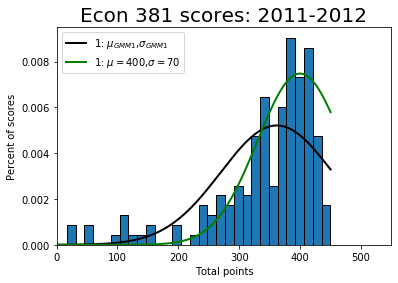

In [50]:
count, bins, ignored = plt.hist(pts, num_bins, density=True,
edgecolor='k')
plt.title('Econ 381 scores: 2011-2012', fontsize=20)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent of scores')
plt.xlim([0, 550])
dist_pts = np.linspace(0, 450, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM1_4, sig_GMM1_4, 0.0,
                                  450),linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')

dist_pts = np.linspace(0, 450, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, 400, 70, 0.0, 450),
linewidth=2, color='g', label='1: $\mu=400$,$\sigma=70$')
plt.legend(loc='upper left')

In [51]:
def Jac_err4(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    Jac_err = np.zeros((4, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = ((err_vec4(xvals, mu + h_mu, sigma, cut_lb, cut_ub, simple) - 
                      err_vec4(xvals, mu - h_mu, sigma, cut_lb, cut_ub, simple)) / (2 * h_mu)).flatten()
    
    Jac_err[:, 1] = ((err_vec4(xvals, mu, sigma + h_sig, cut_lb, cut_ub, simple) - 
                      err_vec4(xvals, mu, sigma - h_sig, cut_lb, cut_ub, simple)) / (2 * h_sig)).flatten()
    
    return Jac_err



In [54]:
d_err4 = Jac_err4(pts, mu_GMM1_4, sig_GMM1_4, 0.0, 450.0, False)
print(d_err4)

print(W_hat1_4)

SigHat4 = (1 / N) * lin.inv(d_err4.T @ W_hat1_4 @ d_err4)
print(SigHat4)
print('Std. err. mu_hat=', np.sqrt(SigHat4[0, 0]))
print('Std. err. sigma_hat=', np.sqrt(SigHat4[1, 1]))

[[-0.01552585  0.03086036]
 [-0.01186596  0.00386863]
 [ 0.00363825 -0.00488293]
 [ 0.01822032  0.00020489]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[14.31487341  7.78513299]
 [ 7.78513299 10.50017909]]
Std. err. mu_hat= 3.783500152699497
Std. err. sigma_hat= 3.2403979827370315


In [55]:
def get_Err_mat4(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 4
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod, pct_4_mod = model_moments4(mu, sigma, cut_lb, cut_ub)
    
    if simple:
        pts_in_grp1 = pts < 220
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 220) & (pts < 320)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = (pts >= 320) & (pts < 430)
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
        pts_in_grp4 = pts >= 430
        Err_mat[3, :] = pts_in_grp4 - pct_4_mod
    
    else:
        pts_in_grp1 = pts < 220
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 220) & (pts < 320)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = (pts >= 320) & (pts < 430)
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
        pts_in_grp4 = pts >= 430
        Err_mat[3, :] = (pts_in_grp4 - pct_4_mod) / pct_4_mod
    
    return Err_mat
        
        
        

In [59]:
Err_mat4 = get_Err_mat4(pts, mu_GMM1_4, sig_GMM1_4, 0.0, 450.0, True)
VCV2_4 = (1 / pts.shape[0]) * (Err_mat4 @ Err_mat4.T)
print(VCV2_4)
W_hat2_4 = lin.pinv(VCV2_4)
print(W_hat2_4)


[[ 0.07954649 -0.01688414 -0.05806039 -0.00460196]
 [-0.01688414  0.16415575 -0.14190039 -0.00537122]
 [-0.05806039 -0.14190039  0.23773004 -0.03776926]
 [-0.00460196 -0.00537122 -0.03776926  0.04774244]]
[[ 8.05829981 -1.69675743 -0.95525939 -5.40628299]
 [-1.69675743  4.99912898  0.85711961 -4.15949116]
 [-0.95525939  0.85711961  2.9759406  -2.87780081]
 [-5.40628299 -4.15949116 -2.87780081 12.44357496]]


In [66]:
mu_init = 600
sig_init = 196
params_init = np.array([mu_GMM1_4, sig_GMM1_4])
gmm_args = (pts, 0.0, 450.0, W_hat2_4)
results2_4 = opt.minimize(criterion4, params_init, args=(gmm_args),
                          method='L-BFGS-B', bounds=((1e-10, None),
                                                     (1e-10, None)))
mu_GMM2_4, sig_GMM2_4 = results2_4.x
print('mu_GMM2_4=', mu_GMM2_4, ' sig_GMM2_4=', sig_GMM2_4)
results2_4

mu_GMM2_4= 363.9708485120253  sig_GMM2_4= 111.22649279366647


      fun: array([[1.9282664]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.61533067e-06,  9.23705556e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 27
      nit: 8
   status: 0
  success: True
        x: array([363.97084851, 111.22649279])

<IPython.core.display.Javascript object>


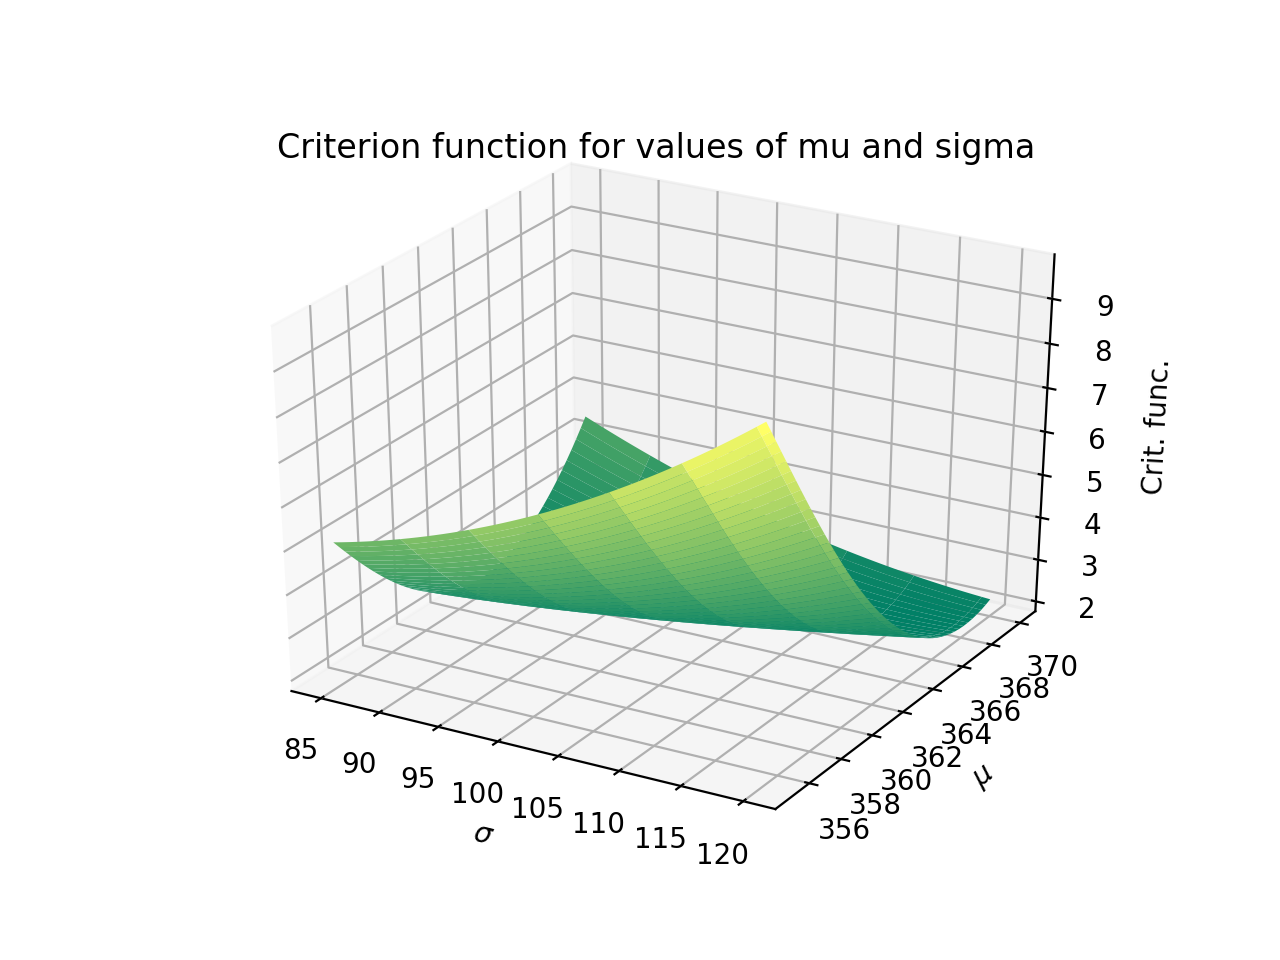

Text(0.5, 0, 'Crit. func.')

In [68]:
%matplotlib notebook
mu_vals = np.linspace(355, 370, 50)
sig_vals = np.linspace(85, 120, 50)
crit_vals4 = np.zeros((50, 50))

for mu_ind in range(50):
    for sig_ind in range(50):
        crit_vals4[mu_ind, sig_ind] = \
        criterion4(np.array([mu_vals[mu_ind], sig_vals[sig_ind]]),
                   pts, 0.0, 450.0, W_hat2_4)

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(sig_mesh, mu_mesh, crit_vals4, rstride=8,
                cstride=1, cmap=cmap1)

ax.set_title('Criterion function for values of mu and sigma')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\mu$')
ax.set_zlabel(r'Crit. func.')
        
        
        

In [70]:
d_err4_2 = Jac_err4(pts, mu_GMM2_4, sig_GMM2_4, 0.0, 450.0, False)
print(d_err4_2)
print(W_hat2_4)

SigHat4_2 = (1 / N) * lin.inv(d_err4_2.T @ W_hat2_4 @ d_err4_2)
print(SigHat4_2)
print('Std. err. mu_hat=', np.sqrt(SigHat4_2[0, 0]))
print('Std. err. sigma_hat=', np.sqrt(SigHat4_2[1, 1]))


[[-0.01777747  0.03268933]
 [-0.00680568 -0.00017871]
 [ 0.00295438 -0.00385842]
 [ 0.01393849 -0.0030452 ]]
[[ 8.05829981 -1.69675743 -0.95525939 -5.40628299]
 [-1.69675743  4.99912898  0.85711961 -4.15949116]
 [-0.95525939  0.85711961  2.9759406  -2.87780081]
 [-5.40628299 -4.15949116 -2.87780081 12.44357496]]
[[2.73366626 2.08456054]
 [2.08456054 2.20840867]]
Std. err. mu_hat= 1.6533802539513418
Std. err. sigma_hat= 1.4860715570595169
